In [7]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import json


In [8]:
coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json'
coco_img_path  = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/'

In [77]:
# returns the cropped COCO images
class CustomCOCO():

    def __init__(self, json_path, img_path):
        data = json.load(open(json_path))
        self.json_path = json_path
        self.anot = data['annotations']

        #separate image_ids, keypoints, and bbox from data
        self.img_path  = img_path
        self.target_height = 256
        self.target_width = 192

    def __len__(self):
        return len(self.anot)

    def __getitem__(self, idx):
        self.load_img(idx)
        img = self.resized_image
        self.create_heatmap()
        hp = np.array(self.heatmap_list)
        return img, hp
    
    def _target_image_into(self, index):
        target_data = self.anot[index]
        self.target_kp = target_data['keypoints']
        self.target_bbox = target_data['bbox']
        self.target_id = target_data['image_id']

    def _crop_img(self):
        X,Y,width,height = self.target_bbox
        X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1

        if height/width < 4/3:
            original_height = height
            height = int(3*width/4)
            height_change = height - original_height
            ## 5% padding for robustness
            original_width = width
            width = int(width * 1.05)
            width_change = width - original_width

        else:
            original_width = width
            width = int(3*height/4)
            width_change = width - original_width
            ## 5% padding for robustness
            original_height = height
            height = int(height * 1.05)
            height_change = height - original_height

        self.cropped_image = self.target_image[Y-int(height_change/2):Y+height-int(height_change/2), X-int(width_change/2):X-int(width_change/2)+width]
        
        self.width = width; self.height = height
        self.width_trans = X - int(width_change/2)
        self.height_trans = Y - int(height_change/2)

    def _resize_img(self):
        dim = (self.target_width, self.target_height)
        self.resized_image = cv2.resize(self.cropped_image, dim, interpolation=cv2.INTER_AREA)

    def load_img(self, index):
        self._target_image_into(index)
        target_img_path = self.img_path +"000000" + str(self.target_id) + '.jpg'
        self.target_image = cv2.imread(target_img_path)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        
        # apply transformation
        self._crop_img()
        self._resize_img()

        
    def show_img(self):
        plt.imshow(self.resized_image)
        plt.show()

    def _create_kp_list(self):
        # execute after load_img() 
        self.keypoint = []
        self.keypoint_confidence = []
        for i, k in enumerate(self.target_kp):
            if i%3 != 0:
                continue
            if k != 0:
                x = self.target_kp[i] #k
                y = self.target_kp[i+1]
                confidence = self.target_kp[i+2]

                x = (x-self.width_trans)*self.target_width/self.width 
                y = (y-self.height_trans)*self.target_height/self.height
                if x<0 or y<0:
                    self.keypoint.append((0,0))
                    continue
                coordinate = (y,x)
                
                self.keypoint.append(coordinate)
                self.keypoint_confidence.append(confidence)

    def create_heatmap(self):

        def gaussian_heatmap(image_size, center_point):
            ro = 0
            center_x = center_point[0]
            center_y = center_point[1]

            grid_y, grid_x = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
            x = grid_x - center_x
            y = grid_y - center_y

            return np.exp(-1 * (x ** 2 - 2 * ro * x * y + y**2) / (2 * (1 - ro**2)))
        
        self.heatmap_list = []
        self._create_kp_list()
        for i, kp in enumerate(self.keypoint):
            heatmap_i = gaussian_heatmap((192, 256), kp)
            self.heatmap_list.append(heatmap_i)

    def show_heatmap(self):
        h = np.stack(self.heatmap_list)
        plt.imshow(h.max(axis=0)) 

In [78]:
mycoco = CustomCOCO(coco_json_path, coco_img_path)

In [83]:
img, hp = mycoco[12]

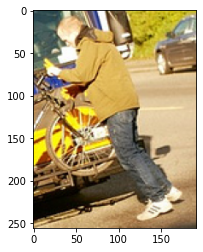

In [84]:
plt.imshow(img)

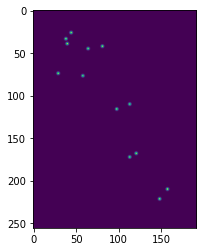

In [86]:
plt.imshow(np.stack(hp).max(axis=0))